En este cuaderno estudiaremos las características de los datos del dataset de Anemia

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split    
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, log_loss)
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

Los datos consisten en 100,000 observaciones del espacio tomadas por el SDSS (Sloan Digital Sky Survey). Cada observación está descrita por 17 columnas de características y 1 columna de clase que la identifica como una estrella, galaxia o cuásar.

obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS 
alpha = Right Ascension angle (at J2000 epoch)
delta = Declination angle (at J2000 epoch)
u = Ultraviolet filter in the photometric system
g = Green filter in the photometric system
r = Red filter in the photometric system
i = Near Infrared filter in the photometric system
z = Infrared filter in the photometric system
run_ID = Run Number used to identify the specific scan
rereun_ID = Rerun Number to specify how the image was processed
cam_col = Camera column to identify the scanline within the run
field_ID = Field number to identify each field
spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
class = object class (galaxy, star or quasar object)
redshift = redshift value based on the increase in wavelength
plate = plate ID, identifies each plate in SDSS
MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

Obtenemos los valores a predecir provenientes de la columna "class" de nuestro dataset. Dibujamos cuantos ejemplos clasifica por cada uno de los ejemplos

<Axes: xlabel='class', ylabel='count'>

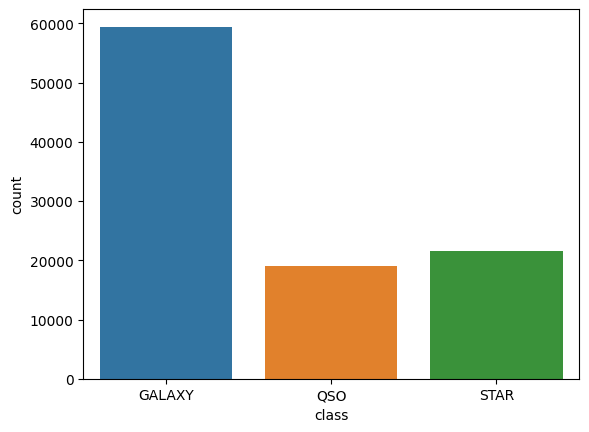

In [39]:
path = 'C:/Users/cmari/Desktop/Quinto/Capgemini/AnemiaProject/data/raw/star_classification.csv'
data = pd.read_csv(path)

data.dropna(subset=['class'], inplace=True)

data = data[data['u']!=-9999]

X_data = data.drop('class', axis=1)
Y_data = data['class']

sns.countplot( x= Y_data, hue=Y_data)

Podemos ver que la mayoría de los ejemplos son Galaxias, algo que es relevante a tener en cuenta para las futuras predicciones

Antes de continuar con el procesado de los datos, eliminamos las columnas correspondientes a identificadores de imágenes y objetos y que no van a sernos de ayuda para nuestro estudio.

In [40]:
X_data = X_data.drop(['run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'obj_ID'], axis=1)


In [41]:
X_data.head()

,alpha,delta,u,g,r,i,z,redshift,plate,MJD,fiber_ID
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,5812,56354,171
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,10445,58158,427
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,4576,55592,299
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,9149,58039,775
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,6121,56187,842


In [42]:
X_data.describe()

,alpha,delta,u,g,r,i,z,redshift,plate,MJD,fiber_ID
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,177.628653,24.135552,22.080679,20.631583,19.645777,19.084865,18.768988,0.576667,5137.027890,55588.653687,449.315613
std,96.502612,19.644608,2.251068,2.037384,1.854763,1.757900,1.765982,0.730709,2952.312485,1808.492217,272.498252
min,0.005528,-18.785328,10.996230,10.498200,9.822070,9.469903,9.612333,-0.009971,266.000000,51608.000000,1.000000
25%,127.517698,5.147477,20.352410,18.965240,18.135795,17.732280,17.460830,0.054522,2526.000000,54234.000000,221.000000
50%,180.900527,23.646462,22.179140,21.099930,20.125310,19.405150,19.004600,0.424176,4987.000000,55869.000000,433.000000
75%,233.895005,39.901582,23.687480,22.123775,21.044790,20.396510,19.921120,0.704172,7400.500000,56777.000000,645.000000
max,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,7.011245,12547.000000,58932.000000,1000.000000


Observamos que para las el filtro de luz ultraviolet, el verde, y el infrarrojo ('z') tenemos como valor mínimo -9999, algo extraño, dado que la media se encuentra en torno al 20-22 y su desviación típica  se encuentra en torno a los 31.75

Observamos como la el filtro de luz ultravioleta, así como el filtro de luz verde poseen estadísticos muy parecidos. Más tarde veremos en función de si su clase es una u otra, si poseen distirbuciones distintas.
Comprobamos rapidamente también que no existan valores nulos.

In [43]:
print(X_data.isna().sum())


alpha       0
delta       0
u           0
g           0
r           0
i           0
z           0
redshift    0
plate       0
MJD         0
fiber_ID    0
dtype: int64


Pasamos a analizar esos ejemplos donde el filtro de luz ultravioleta y verde es -9999

In [44]:
count_eje = (X_data['g']==-9999).sum()
print(count_eje)

print(X_data[X_data['u']==-9999])

0
Empty DataFrame
Columns: [alpha, delta, u, g, r, i, z, redshift, plate, MJD, fiber_ID]
Index: []


In [45]:
X_data =  X_data[X_data['u']!=-9999]

Dado que desconozco si es un error, o si ha sido un fallo en la medición, pero puede que afecte a la medición de sus distribuciones y demás, elimino dicho ejemplo de mi dataset

Realizamos ahora un pequeño estudio sobre como se distribuyen cada una de las variable, para obtener una idea más clara de qué variables podríamos escoger para nuestro futuro modelo

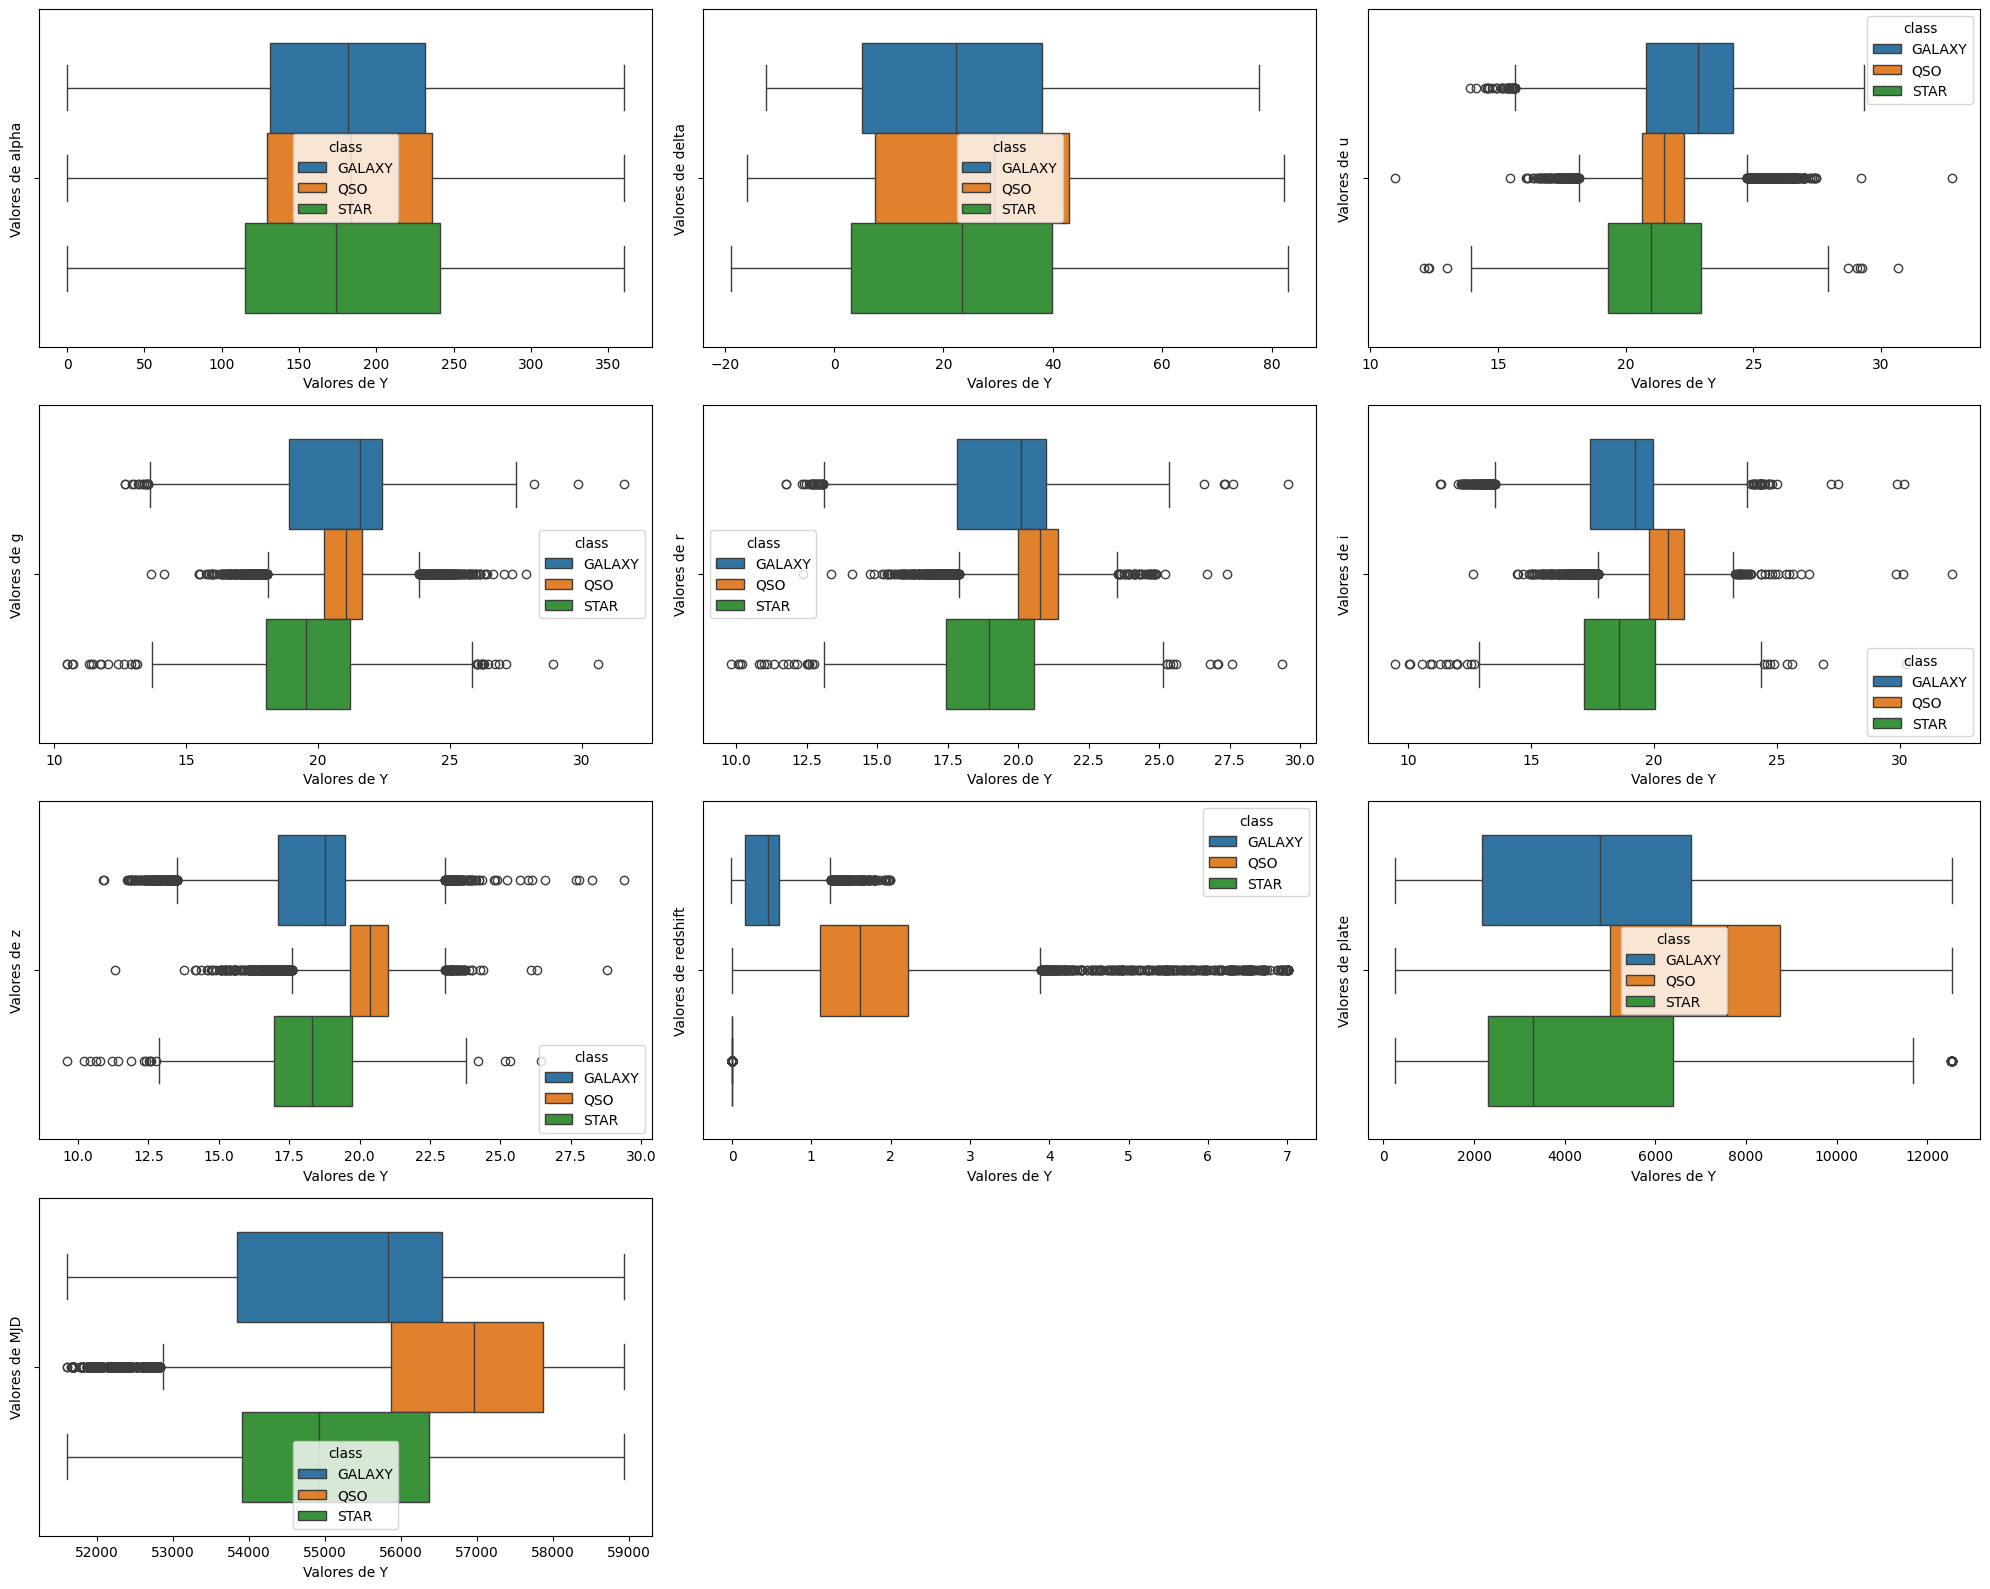

In [29]:
fig, axes = plt.subplots(4, 3, figsize=(20, 16), sharex=False)
for column, axis in zip(X_data.columns, axes.flatten()):
    sns.boxplot(x=X_data[column], hue=Y_data, ax=axis)
    axis.set_xlabel('Valores de Y') 
    axis.set_ylabel('Valores de {}'.format(column))  

axes.flatten()[-1].set_visible(False)
axes.flatten()[-2].set_visible(False)
fig.tight_layout()

Dibujo detalladamente las variables más destacadas

<Axes: xlabel='z'>

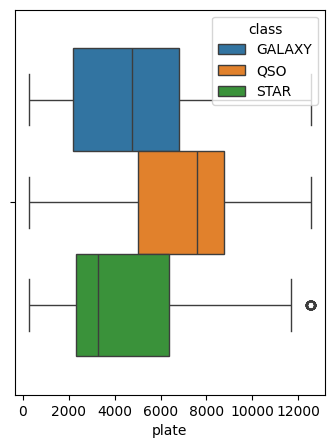

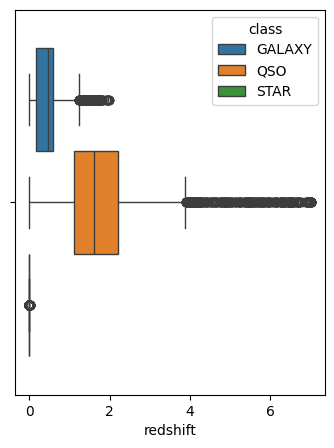

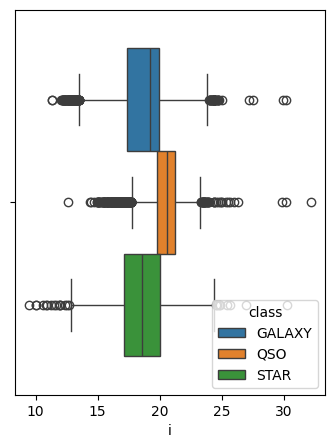

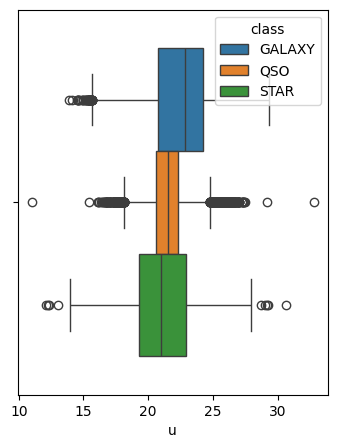

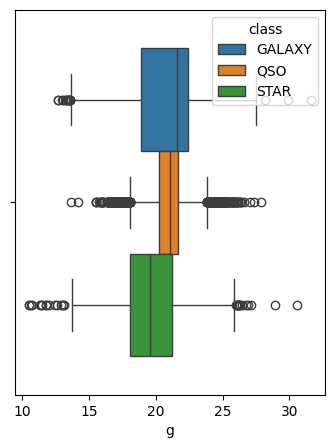

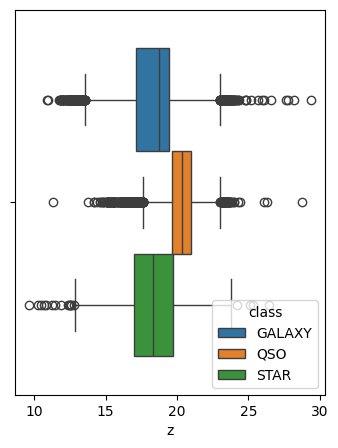

In [30]:
fig = plt.figure(figsize=(4,5))
sns.boxplot(x=X_data['plate'], hue='class',data=data)
fig2 = plt.figure(figsize=(4, 5))
sns.boxplot(x=X_data['redshift'], hue='class',data=data)
fig3 = plt.figure(figsize=(4, 5))
sns.boxplot(x=X_data['i'], hue='class',data=data)
fig3 = plt.figure(figsize=(4, 5))
sns.boxplot(x=X_data['u'], hue='class',data=data)
fig3 = plt.figure(figsize=(4, 5))
sns.boxplot(x=X_data['g'], hue='class',data=data)
fig3 = plt.figure(figsize=(4, 5))
sns.boxplot(x=X_data['z'], hue='class',data=data)

De aquí podemos obtener como conclusion que variables como 'plate' o 'MJD' serán buenas variables a tener en cuenta para nuestras predicciones, dado que sus distribuciones varían entre las distintas clasificaciones. A pesar de tener algunos valores dispersos, las variables 'u', 'z', y 'g' también las escogeremos para nuestro entrenamiento

Vamos a observar si existieran correlaciones entre alfunas de las variables

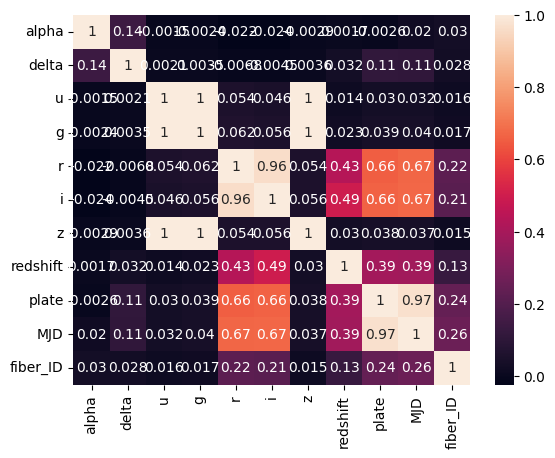

<Figure size 1500x800 with 0 Axes>

In [11]:
corr = X_data.corr()
sns.heatmap(corr, annot=True)
plt.figure(figsize=(15, 8))
plt.show()

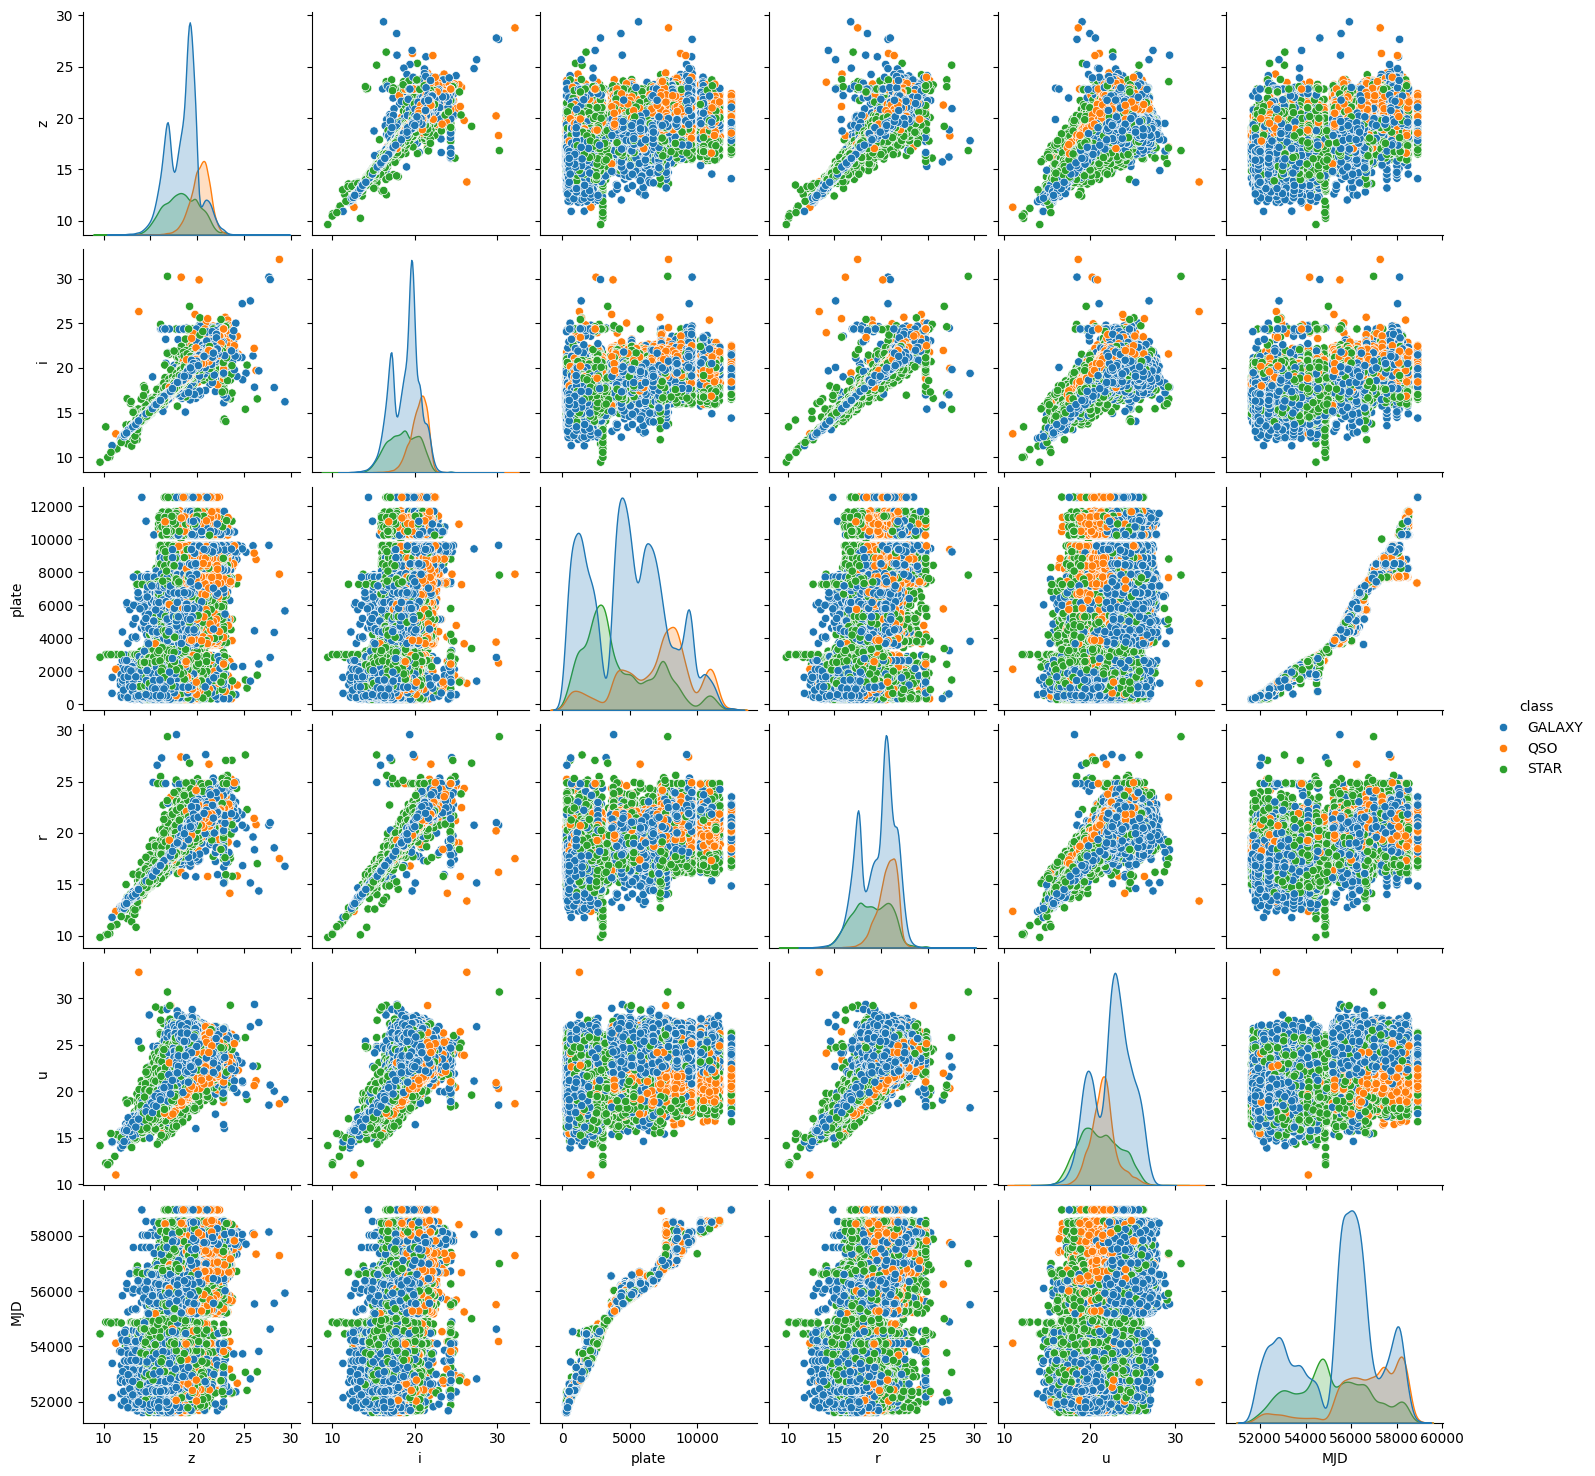

In [33]:
sns.pairplot(pd.concat([X_data[['z', 'i', 'plate', 'r', 'u', 'MJD']], Y_data], axis=1), hue='class')

Podemos detectar algo de relación en la clasificación entre los valores de 'Plate' y 'MJD'. Además observamos que variables como 'u', 'r', 'z', poseen rangos de valores similares, destacando la gran mayoría de ejemplos que clasifican como galaxias.

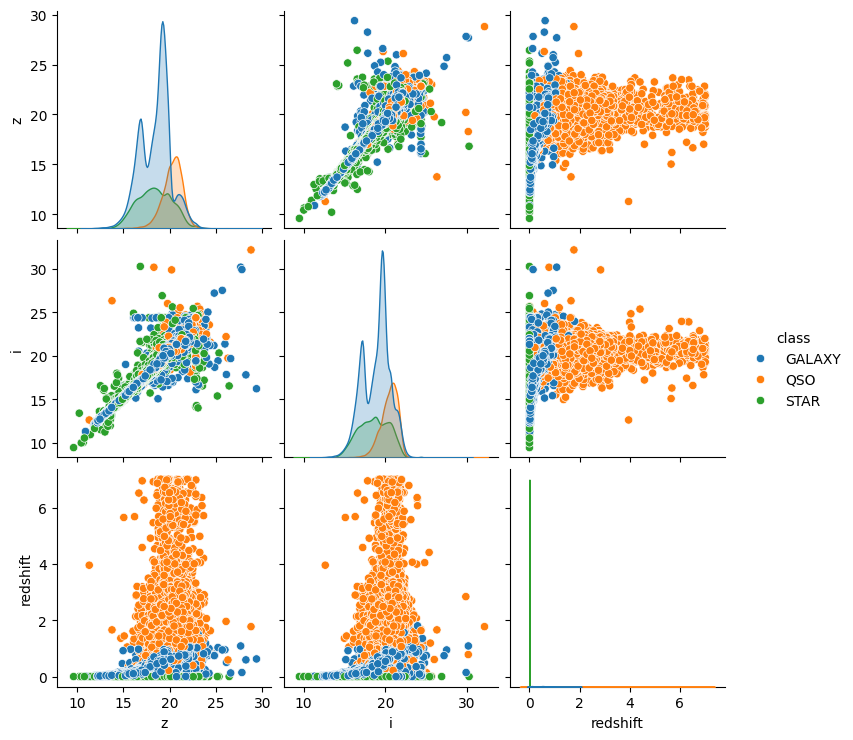

In [34]:
sns.pairplot(pd.concat([X_data[['z', 'i', 'redshift']], Y_data], axis=1), hue='class')

Se observa que los valores elevados de nuestra variable redshift se corresponden con las clasificaciones de 'QSO'

In [35]:
X_data.head()

,alpha,delta,u,g,r,i,z,redshift,plate,MJD,fiber_ID
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,5812,56354,171
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,10445,58158,427
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,4576,55592,299
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,9149,58039,775
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,6121,56187,842


Dado que no existen valores nulos, no aplicamos ningún Imputer. De manera análoga, dado que no existen variables categóricas, no aplicamos OneHoteEconding, el cual nos serviría para dichas variables.

In [28]:
predictions = model.predict(X_test)

# Evaluando el modelo
print("Matriz de confusión:")
print(confusion_matrix(y_test, predictions))
print("\nReporte de clasificación:")
print(classification_report(y_test, predictions))

Matriz de confusión:
[[11710   126    24]
 [  269  3527     1]
 [    2     0  4341]]

Reporte de clasificación:
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     11860
         QSO       0.97      0.93      0.95      3797
        STAR       0.99      1.00      1.00      4343

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.98     20000
weighted avg       0.98      0.98      0.98     20000

